<a href="https://colab.research.google.com/github/sauddy/DPCNet/blob/main/DPCNet_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
####mount the drive if running from Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os
import csv

## Modules to check the performance of the code
from time import process_time 
!pip install memory_profiler ## When running from Google Colab
import memory_profiler as mem_profile
print('Memory (Before): {}Mb'.format(mem_profile.memory_usage()))


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

from tensorflow import keras
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score
from tensorflow import keras as k



  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=0b28c0dc1f7c26f3d2eb1b753e8686e1913f474085d7dcc11aba25cfe09b961d
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler
Memory (Before): [151.15234375]Mb


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num TPUs Available: ", len(tf.config.list_physical_devices('TPU')))
print(tf.__version__)

Num GPUs Available:  1
Num TPUs Available:  0
2.8.0


In [6]:
############ Please provide the same path to the code directory if using Colab################

Path_gdrive= '/content/drive/MyDrive/Data_Mining/PC/SOMPC' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPNNet
import sys
try: ## tries to find the modules in the local directory first
  current_directory = os.getcwd()
  path = current_directory + '/' # For local computer 
#   path = '' # For local computer  
  sys.path.append(path+'MODULES_DPNNeT')
  import data_processing_RT as dp
  import deep_models as dm
  import other_cnns as ocn

  ########### Folders to save the processed data, files and figures when using Local computer ##############
  output_folder_list = ['data_folder','figures','saved_model']
  for file in output_folder_list:
    try:
        os.makedirs(file)
    except OSError:
        print ("Creation of the directory %s failed/ not needed as it already exit" % file)
    else:
        print ("Successfully created the directory %s" % file)
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  #(data folder are a directory above the directory containing the notebook)
  try:
    path = Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPNNeT')
    import data_processing_RT as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figures
    !mkdir -p figures_paper
    !mkdir -p saved_model
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")



Creation of the directory data_folder failed/ not needed as it already exit
Creation of the directory figures failed/ not needed as it already exit
Creation of the directory saved_model failed/ not needed as it already exit
[INFO] Modules imported


## Creating a csv with simulations params and path to each RT images

In [10]:
## Taking a look at the paramter file 
parameter_df = dp.load_parameter_csv(path)
parameter_df['Planet_Count'] = (parameter_df.loc[:, ['Planet_Mass1', 'Planet_Mass2', 'Planet_Mass3']] != 0).sum(axis=1)
parameter_df

,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3,Planet_Count
0,0.002110,0.00237,0.001880,0.1,0.03000,0.160000,0.0475,1.0,0.0,1.050,2.16,3.03,3
1,0.001850,0.00195,0.002710,0.1,0.00050,0.030000,0.0389,1.0,0.0,1.160,2.00,2.99,3
2,0.001340,0.00296,0.002790,0.1,0.00999,0.160000,0.0518,1.0,0.0,0.874,1.83,2.98,3
3,0.000492,0.00129,0.002130,0.1,0.00999,0.160000,0.0668,1.0,0.0,1.110,2.05,3.13,3
4,0.002360,0.00162,0.000963,0.1,0.00999,0.000157,0.0754,1.0,0.0,0.954,1.82,2.96,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001120,0.00000,0.000000,0.1,0.03000,0.160000,0.0675,1.0,0.0,1.030,1.84,3.32,1
96,0.000322,0.00000,0.000000,0.1,0.00050,0.160000,0.0425,1.0,0.0,1.160,2.11,3.04,1
97,0.002500,0.00000,0.000000,0.1,0.00999,0.000157,0.0375,1.0,0.0,0.867,1.89,3.24,1
98,0.001310,0.00000,0.000000,0.1,0.00999,0.030000,0.0925,1.0,0.0,1.080,2.03,3.28,1


In [11]:
############# Address to the data folder ###################

# ## updating the image paths once the transfer is done
list_RT_path = glob.glob(path+ 'image_directory/'+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim

## When using the local M1
# list_sorted_RT_path  = sorted(list_RT_path, key=lambda x: int(x.split('/')[1].split('_')[2])) ## sorting the images


# ## For google colab this needs to be updated
import re
list_sorted_RT_path  = sorted(list_RT_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1]) ## sorting the images

# print(list_sorted_RT_path[0])


# The idea is to generate a dataframe with the parameters and the path to the images
data_complete = dp.create_complete_data_csv(list_sorted_RT_path,path)
# data_complete
## Removing the nan if any
data_complete.isna().sum()  # summing the number of na
data_complete= data_complete.dropna()
data_complete['Planet_Count'] = (data_complete.loc[:, ['Planet_Mass1', 'Planet_Mass2', 'Planet_Mass3']] != 0).sum(axis=1)
data_complete

[INFO]: Importing path for all the RT images
[INFO]: Contatinating the paths of all the RT images is now complete


,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3,image_path,Planet_Count
0,703.333333,790.0,626.666667,0.1,0.03000,0.16,0.0475,1.0,0.0,1.05,2.16,3.03,/content/drive/MyDrive/ISU/DPNNet-RT/image_dir...,3
1,703.333333,790.0,626.666667,0.1,0.03000,0.16,0.0475,1.0,0.0,1.05,2.16,3.03,/content/drive/MyDrive/ISU/DPNNet-RT/image_dir...,3
2,703.333333,790.0,626.666667,0.1,0.03000,0.16,0.0475,1.0,0.0,1.05,2.16,3.03,/content/drive/MyDrive/ISU/DPNNet-RT/image_dir...,3
3,703.333333,790.0,626.666667,0.1,0.03000,0.16,0.0475,1.0,0.0,1.05,2.16,3.03,/content/drive/MyDrive/ISU/DPNNet-RT/image_dir...,3
4,703.333333,790.0,626.666667,0.1,0.03000,0.16,0.0475,1.0,0.0,1.05,2.16,3.03,/content/drive/MyDrive/ISU/DPNNet-RT/image_dir...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15005,173.333333,0.0,0.000000,0.1,0.00999,0.03,0.0275,1.0,0.0,1.11,1.97,3.16,/content/drive/MyDrive/ISU/DPNNet-RT/image_dir...,1
15006,173.333333,0.0,0.000000,0.1,0.00999,0.03,0.0275,1.0,0.0,1.11,1.97,3.16,/content/drive/MyDrive/ISU/DPNNet-RT/image_dir...,1
15007,173.333333,0.0,0.000000,0.1,0.00999,0.03,0.0275,1.0,0.0,1.11,1.97,3.16,/content/drive/MyDrive/ISU/DPNNet-RT/image_dir...,1
15008,173.333333,0.0,0.000000,0.1,0.00999,0.03,0.0275,1.0,0.0,1.11,1.97,3.16,/content/drive/MyDrive/ISU/DPNNet-RT/image_dir...,1


## Classification

In [12]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
! pip install torchbnn
import torchbnn as bnn
import matplotlib.pyplot as plt

In [13]:
## partition the data csv file into training and testing splits using 85% of
## the data for training and the remaining 15% for testing
split = train_test_split(data_complete, test_size=0.15, random_state=42)
(train, test) = split

## Save the train and the test data for future use as well.
test.to_csv(path+'data_folder/test_dataset.csv')
train.to_csv(path+'data_folder/train_dataset.csv')

## Generate the Normalized data
normed_train_data, normed_test_data, train_labels, test_labels = dp.process_the_disk_attributes(train, test, path)


#### Desired Image resoltuion #####
X_res = Y_res = 64

## Generate the training and the test images 

trainImagesX = dp.load_disk_images(train, X_res, Y_res, Type = "Train")
testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")

Validation_split = 0.15 # 15 percent of the training data is used for validation
print('Memory (After Loading): {}Mb'.format(mem_profile.memory_usage()))
print('There are {} Train, {} Validation and {} Test images'.format(int((1-Validation_split)*len(normed_train_data)),int(Validation_split*len(normed_train_data)),len(normed_test_data)))## check the numbers in each chategory



[INFO] preparing the normalized data training/testing split...
[INFO] Done...
[INFO] Loading images from Train data..
Train Images are loaded
[INFO] Loading images from Test data..
Test Images are loaded
Memory (After Loading): [2059.8671875]Mb
There are 10167 Train, 1794 Validation and 2112 Test images


In [1]:
X_train=trainImagesX
X_test=testImagesX
Y_train=train['Planet_Count'].values - 1
Y_test=test['Planet_Count'].values - 1

a_set = set(Y_train)
number_of_unique_values = len(a_set)
print(number_of_unique_values)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

NameError: ignored

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D
from keras.utils import np_utils

n_classes = 3
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (11962,)
Shape after one-hot encoding:  (11962, 3)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

# build a sequential model
model_alt = Sequential()
model_alt.add(InputLayer(input_shape=(64, 64, 3)))

# 1st conv block
model_alt.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model_alt.add(MaxPool2D(pool_size=(1, 1), padding='same'))
# 2nd conv block
model_alt.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model_alt.add(MaxPool2D(pool_size=(1, 1), padding='same'))
model_alt.add(BatchNormalization())
# ANN block
model_alt.add(Flatten())
model_alt.add(Dense(units=128, activation='relu'))
model_alt.add(Dense(units=128, activation='relu'))
model_alt.add(Dropout(0.25))
# output layer
model_alt.add(Dense(units=3, activation='softmax'))

In [ ]:
# compile model
model_alt.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics=['accuracy'])
# fit on data for 30 epochs
history_alt = model_alt.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 15s 140ms/step - loss: 6.2322 - accuracy: 0.6015 - val_loss: 1.3249 - val_accuracy: 0.6951
Epoch 2/100
94/94 [==============================] - 12s 126ms/step - loss: 0.6547 - accuracy: 0.6712 - val_loss: 1.0559 - val_accuracy: 0.6951
Epoch 3/100
94/94 [==============================] - 12s 126ms/step - loss: 0.5333 - accuracy: 0.7087 - val_loss: 0.8291 - val_accuracy: 0.6993
Epoch 4/100
94/94 [==============================] - 12s 126ms/step - loss: 0.6195 - accuracy: 0.6941 - val_loss: 0.9784 - val_accuracy: 0.3939
Epoch 5/100
94/94 [==============================] - 12s 126ms/step - loss: 0.8329 - accuracy: 0.5681 - val_loss: 1.0615 - val_accuracy: 0.6951
Epoch 6/100
94/94 [==============================] - 12s 124ms/step - loss: 0.9865 - accuracy: 0.6721 - val_loss: 0.9071 - val_accuracy: 0.6951
Epoch 7/100
94/94 [==============================] - 12s 125ms/step - loss: 0.9038 - accuracy: 0.6721 - val_loss: 0.8523 - val_accuracy:

KeyboardInterrupt: ignored

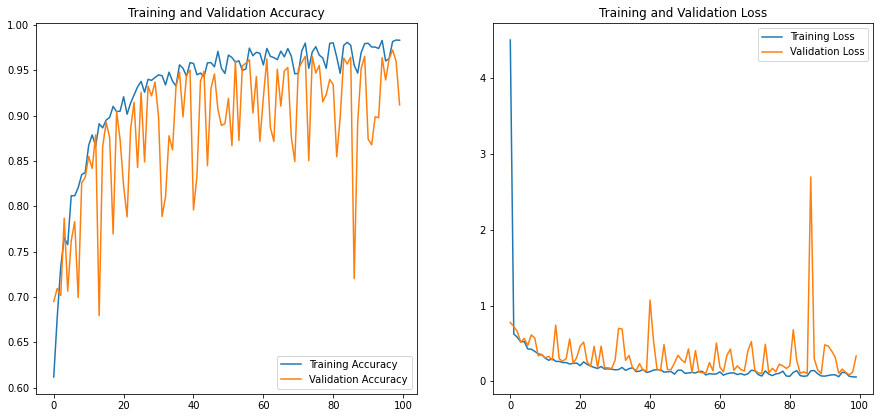

In [ ]:
acc = history_alt.history['accuracy']
val_acc = history_alt.history['val_accuracy']
loss = history_alt.history['loss']
val_loss = history_alt.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing.image import image
from keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt

def unseen_data_test_alt(path, image_name, model):
    image = cv2.imread(path+image_name)  
    crop_image = cv2.resize(image, (X_res, Y_res))
    crop_image = k.preprocessing.image.img_to_array(crop_image)
    datagen = k.preprocessing.image.ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,rescale= 1.0/255.0)
    crop_image = datagen.standardize(np.copy(crop_image))
    print('Original Image')
#     print(img)
    plt.imshow(crop_image)
    crop_image = np.expand_dims(crop_image, axis = 0)
    img_data = preprocess_input(crop_image)
    a = np.argmax(model.predict(img_data), axis = 1)
    b = model.predict(img_data)

    if a == 0:
        print("one planet system",b)
    elif a == 1:
        print("two planet system",b)
    else:
        print("three planet system",b)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Image
three planet system [[0. 0. 1.]]


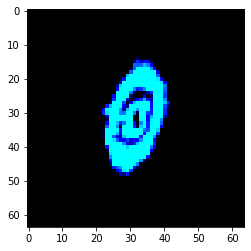

In [ ]:
unseen_data_test_alt('/content/drive/MyDrive/ISU/DPNNet-RT/unseen_data/', 'IM_Lup_ALMA_NRAO.jpg', model)

(2112,)
(2112, 3)


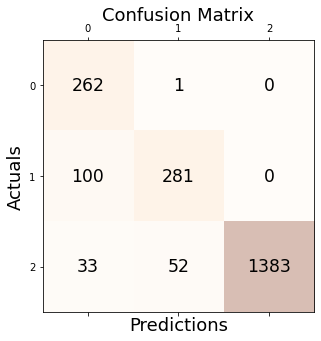

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = np.argmax(model_alt.predict(X_test), axis = 1)
y_test = np.argmax(Y_test, axis = 1)
print(y_pred.shape)
print(Y_test.shape)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.912


## Classification-2

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
  
from sklearn.metrics import classification_report, confusion_matrix
  
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
  
import cv2
  
import warnings
warnings.filterwarnings('ignore')

In [ ]:
base_model = tf.keras.applications.VGG19(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(X_res,Y_res,3)
                     )
  
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
  
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [ ]:
batch_size=50
  
# fit model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=25, callbacks=[early])

Epoch 1/25
374/374 [==============================] - 24s 57ms/step - loss: 0.4552 - accuracy: 0.8152 - val_loss: 0.2488 - val_accuracy: 0.8935
Epoch 2/25
374/374 [==============================] - 20s 54ms/step - loss: 0.2254 - accuracy: 0.9050 - val_loss: 0.1965 - val_accuracy: 0.9214
Epoch 3/25
374/374 [==============================] - 23s 60ms/step - loss: 0.1684 - accuracy: 0.9305 - val_loss: 0.1400 - val_accuracy: 0.9351
Epoch 4/25
374/374 [==============================] - 20s 54ms/step - loss: 0.1398 - accuracy: 0.9401 - val_loss: 0.1172 - val_accuracy: 0.9437
Epoch 5/25
374/374 [==============================] - 20s 54ms/step - loss: 0.1245 - accuracy: 0.9488 - val_loss: 0.1180 - val_accuracy: 0.9446
Epoch 6/25
374/374 [==============================] - 20s 54ms/step - loss: 0.1268 - accuracy: 0.9514 - val_loss: 0.0883 - val_accuracy: 0.9612
Epoch 7/25
374/374 [==============================] - 20s 54ms/step - loss: 0.0988 - accuracy: 0.9585 - val_loss: 0.1042 - val_accuracy:

In [ ]:
model.save("Model.h5")

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.9841163754463196\nValidation Accuracy: 0.9876893758773804')

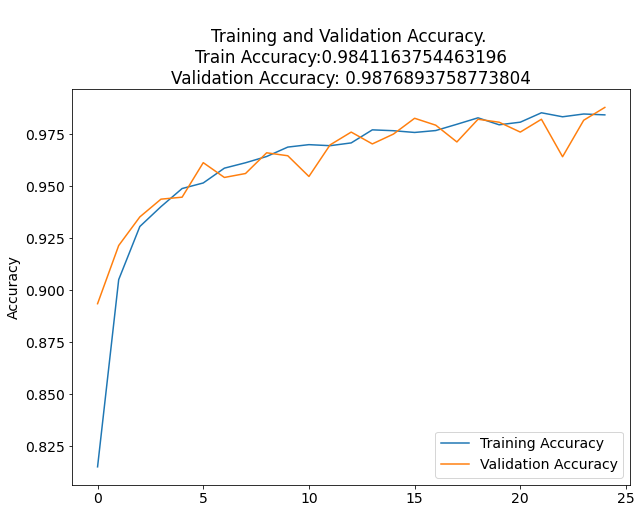

In [ ]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


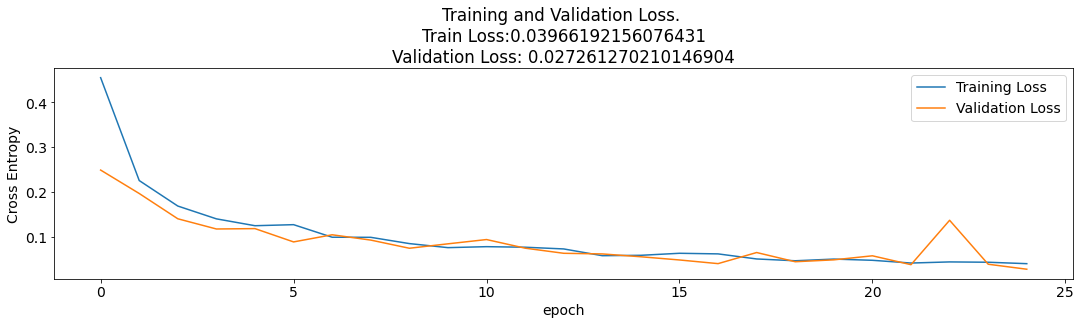

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
accuracy_score = model.evaluate(X_test, Y_test)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

66/66 [==============================] - 3s 46ms/step - loss: 0.0273 - accuracy: 0.9877
[0.027261270210146904, 0.9876893758773804]
Accuracy: 98.7689%
Loss:  0.027261270210146904


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = np.argmax(model.predict(X_test), axis = 1)
y_test = np.argmax(Y_test, axis = 1)
print(y_pred.shape)
print(Y_test.shape)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Image
two planet system [[0.0000000e+00 1.0000000e+00 1.2941382e-26]]


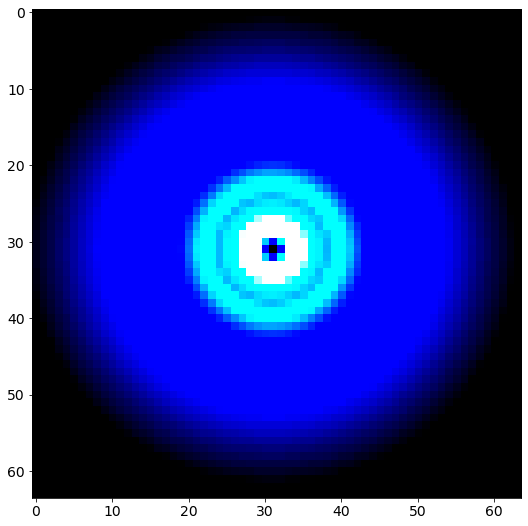

In [ ]:
unseen_data_test_alt('/content/drive/MyDrive/ISU/DPNNet-RT/unseen_data/', 'image_1.png', model)